In [17]:
import tensorflow as tf



In [18]:
base_model = tf.keras.models.load_model('../keras_checkpoints/MTT_musicnn.h5')

In [3]:
print(base_model)

In [19]:
base_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 187, 96, 1)] 0                                            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 187, 96, 1)   4           input_1[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_Pad (TensorFlowOpLa (None, 193, 96, 1)   0           batch_normalization[0][0]        
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 187, 59, 204) 54468       tf_op_layer_Pad[0][0]            
______________________________________________________________________________________________

In [20]:
truncated_model = tf.keras.Model(base_model.input,base_model.get_layer('bn_dense').output)
print(truncated_model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 187, 96, 1)] 0                                            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 187, 96, 1)   4           input_1[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_Pad (TensorFlowOpLa (None, 193, 96, 1)   0           batch_normalization[0][0]        
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 187, 59, 204) 54468       tf_op_layer_Pad[0][0]            
______________________________________________________________________________________________

In [6]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  0


In [23]:
%run preprocess_librosa drumsamp_spec

This is expected if you are splitting computations into different machines..
..because all these machines are writing to this folder. Otherwise, check your config_file!
Audio representation folder: /workspaces/classification/data/audio_representation/drumsamp__time-freq/


In [22]:
from pathlib import Path
files = []
files.extend(Path('../DRUMSAMP/test').glob('**/*.wav'))

def get_path(posix_path):
    splits = str(posix_path).split('/')
    return os.path.join(splits[2], splits[3], splits[4])

files = list(map(get_path, files))
keys = [ f.split('/')[-1].split('.')[-2] for f in files]

id_dict = dict(zip(keys, files))

with open('../data/index/index_DRUMSAMP.tsv', mode='w') as out_file:
    for id, f in id_dict.items():
        out_file.write(f'{id}\t{f}\n')

In [44]:
### Create encoded class files
from pathlib import Path
import json

SET = 'train'
CLASSES = ['cymbal', 'drumloop', 'kick', 'snare', 'tom']

files = []

files.extend(Path(f'../data/audio_representation/drumsamp__time-freq/{SET}').glob('**/*.pk'))

ids = list(map(lambda x: str(x).split('/')[-1].split('.')[-2], files))
classes = list(map(lambda x: x.split('_')[0], ids))

combined = list(zip(ids, list(map(lambda x: str(x), files)), classes))

with open(f'../data/index/{SET}_drumsamp.tsv', mode='w') as out_file:
    for (id, path, clazz) in combined:
        print_list = [0, 0, 0, 0, 0]
        list_idx = CLASSES.index(clazz)
        print_list[list_idx] = 1
        out_file.write("%s\t%s\t%s\n" % (str(id), path, json.dumps(print_list)))


Model: "model_153"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_77 (InputLayer)        [(None, 187, 96, 1)]      0         
_________________________________________________________________
model_152 (Functional)       (None, 200)               782029    
_________________________________________________________________
dropout_73 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_153 (Dense)            (None, 200)               40200     
_________________________________________________________________
dense_154 (Dense)            (None, 5)                 1005      
Total params: 823,234
Trainable params: 41,205
Non-trainable params: 782,029
_________________________________________________________________
None
Fit model on training data
Epoch 1/50
157/157 [==============================] - 252s 2s/step - loss: 0.413

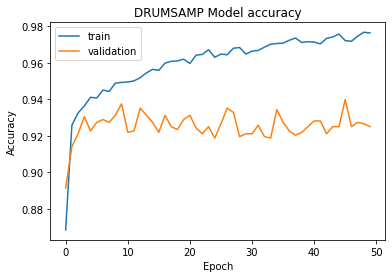

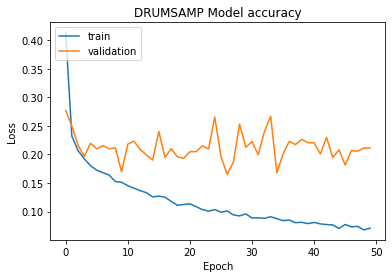

In [133]:
import tensorflow as tf
import pickle
from pathlib import Path
import numpy as np
import random
import ast
import math
import matplotlib.pyplot as plt

BATCH_SIZE = 32

def get_audio(pickle_file):
    audio_rep = pickle.load(pickle_file)
    
    
    audio_rep = np.log10(10000 * audio_rep + 1)

    # let's deliver some data!
    last_frame = int(audio_rep.shape[0]) - int(187) + 1
    
    time_stamp = random.randint(0,last_frame-1)
    return audio_rep[time_stamp : time_stamp+187, : ]

def get_data_for_dataset(path):
    with open(path, mode='r') as input_file:
        for line in input_file.readlines():
            id, pickle_path, clazz = line.strip().split("\t")
            yield id, pickle_path, clazz

def get_data(el):
    pickle_file = tf.io.read_file(el[1])
    
    audio = get_audio(pickle_file)
    classes = ast.literal_eval(tf.keras.backend.get_value(el[2]))

    return np.array(audio).reshape(-1, 187, 96, 1), np.array(classes).reshape(-1, 5)

def get_set(path):
    x_out = []
    y_out = []
    with open(path, mode='r') as input_file:
        for line in input_file.readlines():
            id, pickle_path, clazz = line.strip().split("\t")
            with open(pickle_path, mode='rb') as pickle_file:
                x_out.append(get_audio(pickle_file))
                y_out.append(ast.literal_eval(clazz))
    
    return np.array(x_out).reshape(-1, 187, 96, 1), np.array(y_out).reshape(-1, 5)

# load pre-trained model
base_model = tf.keras.models.load_model('../keras_checkpoints/MTT_musicnn.h5')

# truncate model
truncated_model = tf.keras.Model(base_model.input,base_model.get_layer('bn_dense').output)

# freeze weights
truncated_model.trainable = False


# define model with functional interface
inputs = tf.keras.Input(shape=(187,96,1))

x = truncated_model(inputs, training=False)
x= tf.keras.layers.Dropout(.2)(x)
x = tf.keras.layers.Dense(units=200, activation='relu')(x)

outputs = tf.keras.layers.Dense(len(CLASSES), activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)


# print our model structure
print(model.summary())

# load training data
#X_train, Y_train = get_set('../data/index/train_drumsamp.tsv')

#X_val, Y_val = get_set('../data/index/val_drumsamp.tsv')

X_train, Y_train = get_set('../data/index/train_drumsamp.tsv')
X_val, Y_val = get_set('../data/index/val_drumsamp.tsv')

steps_per_epoch=math.ceil(len(X_train)/BATCH_SIZE)
validation_steps=math.ceil(len(X_val)/BATCH_SIZE)

train_set = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
train_set = train_set.shuffle(buffer_size=len(X_train))
train_set = train_set.repeat()
train_set = train_set.batch(BATCH_SIZE)
train_set = train_set.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

val_set = tf.data.Dataset.from_tensor_slices((X_val, Y_val))
val_set = val_set.shuffle(buffer_size=len(X_val))
val_set = val_set.repeat()
val_set = val_set.batch(BATCH_SIZE)
val_set = val_set.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

callback = tf.keras.callbacks.ModelCheckpoint('../data/index/DRUMSAMP_model_epoch{epoch:02d}-loss_{val_loss:.2f}.hdf5', save_best_only=False, save_freq='epoch')

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[tf.keras.metrics.CategoricalAccuracy()],
)

print("Fit model on training data")
history = model.fit(
    train_set,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    epochs=50,
    # We pass some validation for
    # monitoring validation loss and metrics
    # at the end of each epoch
    validation_data=val_set,
    callbacks=[callback]
)

plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('DRUMSAMP Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('../data/index/plott_acc.png')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('DRUMSAMP Model accuracy')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('../data/index/plot_loss.png')
plt.show()



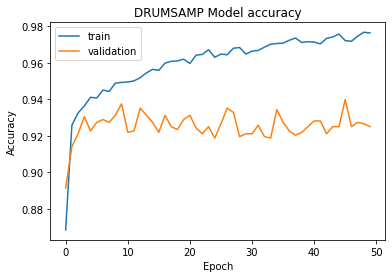

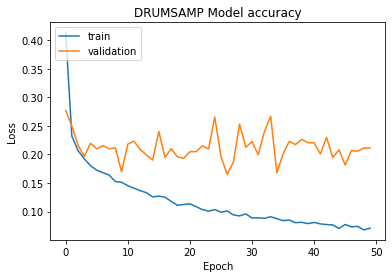

In [135]:
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('DRUMSAMP Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('../data/index/plot_acc.png')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('DRUMSAMP Model accuracy')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('../data/index/plot_loss.png')
plt.show()

In [107]:
X_test, Y_test = get_set('../data/index/test_drumsamp.tsv')

results = model.evaluate(X_test, Y_test, batch_size=64)

print("test loss, test acc:", results)

20/20 [==============================] - 67s 3s/step - loss: 0.5040 - categorical_accuracy: 0.8416
test loss, test acc: [0.5040231943130493, 0.8416000008583069]


In [141]:
from pathlib import Path

X_test, Y_test = get_set('../data/index/val_drumsamp.tsv')

test_steps=math.ceil(len(X_test)/BATCH_SIZE)

test_set = tf.data.Dataset.from_tensor_slices((X_test, Y_test))
test_set = test_set.shuffle(buffer_size=len(X_test))
test_set = test_set.repeat()
test_set = test_set.batch(BATCH_SIZE)
test_set = test_set.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

files = []
files.extend(Path('../data/index').glob('*.hdf5'))

files = list(map(lambda x: str(x), files))
files = sorted(files, key=lambda x: x.split('_')[2].split('-')[0])

results = []

for id, f in enumerate(files):
    evaluation_model = tf.keras.models.load_model(f)
    result = evaluation_model.evaluate(test_set, steps=test_steps)
    results.append(result)

acc_results = list(map(lambda x: x[0], results))
loss_results = list(map(lambda x: x[1], results))

plt.plot(np.array(acc_results))
plt.title('DRUMSAMP Model Loss testset')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Loss'], loc='upper left')
plt.savefig('../data/index/plot_test_loss.png')
plt.show()

plt.plot(np.array(loss_results))
plt.title('DRUMSAMP Model Accuracy testset')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Accuracy'], loc='upper left')
plt.savefig('../data/index/plot_test_acc.png')
plt.show()

40/40 [==============================] - 56s 1s/step - loss: 0.2175 - categorical_accuracy: 0.9242


NameError: name 'hnp' is not defined